# [Practical Assignment] Visual computing: image compression

__Students:__
- **Hernane Braga Pereira** - 2014112627
- **Araceli Marcia Saldanha** - 2012038330



__Problem Statement:__

Implement a function to compress and decompress an image and present the PSNR and compress ratio. Show your intermediates results in the jupyter notebook.


## Notebook steps

1. __Load image in grayscale__


2. __Removing high frequencies coefficients__


3. __Compression__
    1. Huffman coding
    2. Transforming image to a sequence of 0's and 1's
    3. Creating header file
    3. Salving image in a binary file


4. __Decompression__
    1. Open binary files
    2. Image reconstruction


5. __Final result__

__Loading libraries__

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
from scipy import fftpack
import matplotlib.image as mpimg
import os
from heapq import heappush, heappop, heapify
from collections import defaultdict

__Auxiliary Functions__

In [2]:
# image entropy
def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0, 256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1* (hist*logs).sum()
    
    return entropy

In [3]:
# PSNR
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

# Load image in grayscale

Image shape: (627, 1200)
Image entropy:  6.652667999267578


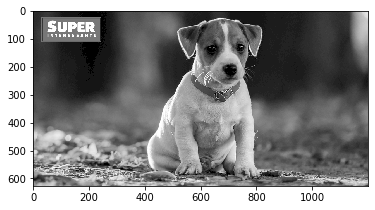

In [4]:
img_path = 'img1.png'

img = cv2.imread(img_path, 0)

plt.imshow(img, cmap='gray')
print("Image shape:", img.shape)
print("Image entropy: ", calcEntropy(img))

# Removing high frequencies coefficients

In [5]:
def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

__Applying  DCT transformation on image__

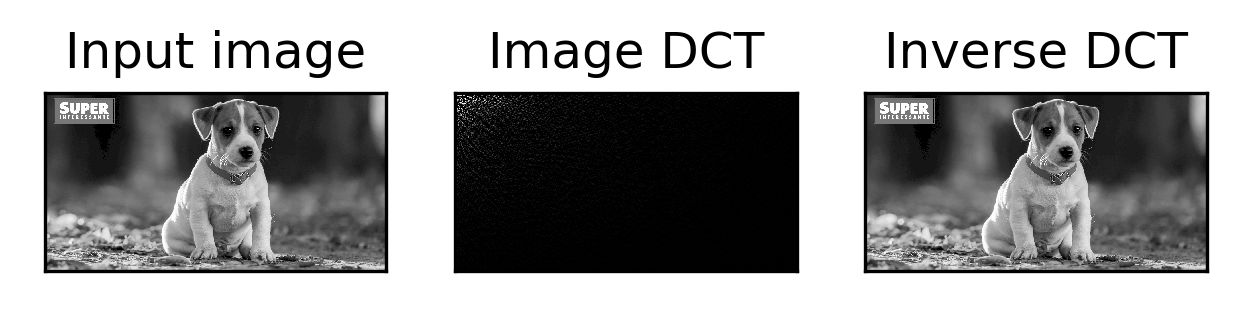

RMSE: 0.000


In [6]:
fig, ax = plt.subplots(1,3, figsize=(5,5), dpi=300)

size = img.shape
IDCT = np.zeros(size, dtype=np.float)
DCT = np.zeros(size, dtype=np.float)

DCT = get_2D_dct(img)
IDCT = get_2d_idct(DCT)

plt.subplot(131),plt.imshow(img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(DCT, cmap = 'gray', clim=(0, 255))
plt.title('Image DCT'), plt.xticks([]), plt.yticks([])


plt.subplot(133),plt.imshow(IDCT, cmap = 'gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

print ("RMSE: %5.3f" % rmse(img, IDCT))

__Function to remove high frequency coefficients__

The function bellow remove the coefficients from the DCT matrix that are below the secondary diagonal. This coefficients are all in high frequencies.

In [7]:
def remove_high_frequency(DCT):
    """ Returns image without high frequency coefficients bellow matrix secondary diagonal
    """
    new_DCT = DCT.copy()

    z = new_DCT.shape[1]-1
    for i in range(new_DCT.shape[0]):
        for j in range(new_DCT.shape[1]):
            if(j >= z):
                new_DCT[i,j] = 0
        z-= 1
    
    new_IDCT = get_2d_idct(new_DCT)
    reconstructed_img = new_IDCT.clip(0, 255)
    reconstructed_img = reconstructed_img.astype('uint8')
    return reconstructed_img

__Applying function__

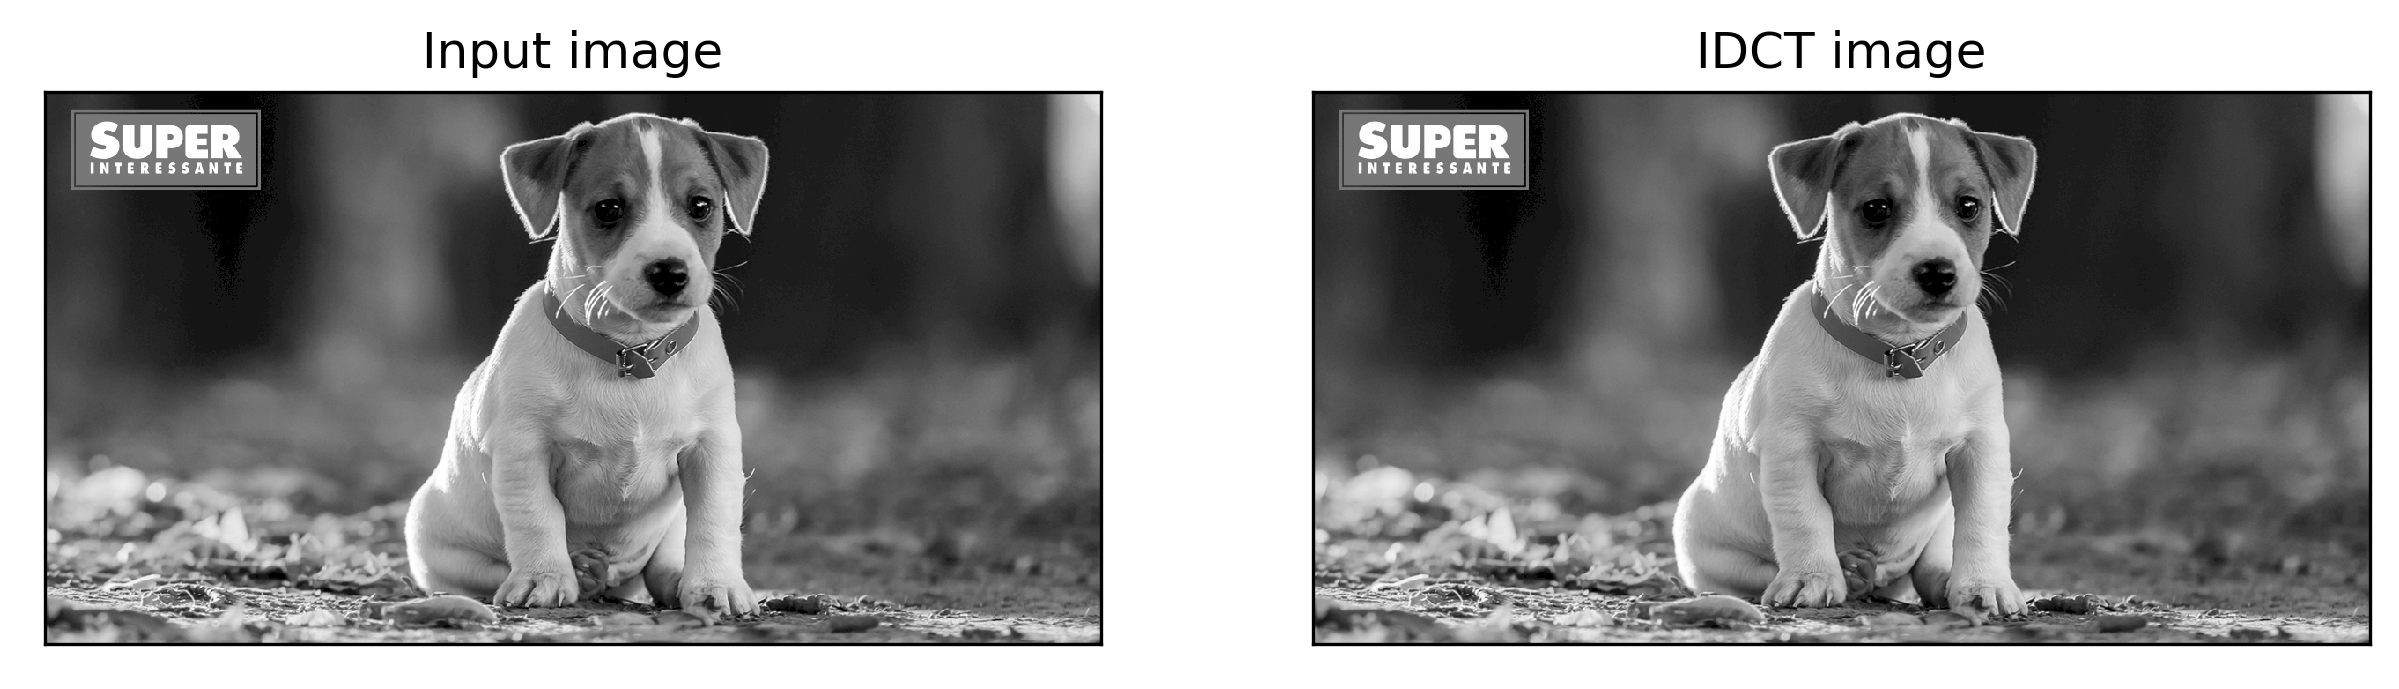

PSNR: 46.590
RMSE: 1.194


In [8]:
new_img = remove_high_frequency(DCT)

fig, ax = plt.subplots(1,2, figsize=(10,10), dpi=300)
plt.subplot(121),plt.imshow(img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(new_img, cmap = 'gray', clim=(0, 255))
plt.title('IDCT image'), plt.xticks([]), plt.yticks([])
plt.show()

print("PSNR: %5.3f" % psnr(img, new_img))
print ("RMSE: %5.3f" % rmse(img, new_img))

# Compression
## Huffman coding

In [9]:
def huffman(huffman_table):
    
    code = defaultdict(list)
    heap = [ ( freq, [ pixel ] ) for pixel,freq in huffman_table.items() ]
    heapify(heap)

    while len(heap) > 1:
        freq_left, simb_left = heappop(heap)
        for pixel in simb_left:
            code[pixel].insert(0,'0')

        freq_right, simb_right = heappop(heap)
        for pixel in simb_right:
            code[pixel].insert(0,'1')

        heappush(heap,(freq_left+freq_right, simb_left+simb_right))

    for key,value in code.items():
        code[key] = ''.join(value)
    
    return code

__Applying Huffman coding__

In [10]:
pixels = new_img.flatten('C')

# Crate table with pixel value and it's frequecy on image
Symbols, Frequency = np.unique(pixels, return_counts=True)

Symbols = list(map(str, Symbols))
huffman_table = list()

for (simb, freq) in zip(Symbols, Frequency):
    huffman_table.append((simb, freq))

huffman_table = dict(huffman_table)

# Huffman coding
dictionary = huffman(huffman_table)

Huffman last 10th code and symbols on dictionary

In [11]:
n = 10
list_to_print = list(dictionary)[:n]
print('Code\tSymbol')
for i in range(0,n,1):
    print(list_to_print[i], '\t', dictionary[list_to_print[i]])

Code	Symbol
10 	 011011111111100
11 	 011011111111101
9 	 00001100111110
12 	 00001100111111
8 	 01101111111111
7 	 0000110011110
13 	 0110111111110
6 	 000011001110
14 	 011011111110
242 	 101110101000


## Transforming image to a sequence of 0's and 1's:

In [12]:
code_list = [list(x) for x in list(dictionary.items())]
pix = [x[0] for x in code_list]
pix = np.array(list(map(int, pix)), dtype=np.uint8)
cod = [x[1] for x in code_list]

string_img = str()

for p in pixels:
    pos = np.where(pix==p)
    string_img = string_img + cod[list(pos[0])[0]]  

In [13]:
print('First 50 elements of the image that will be converted to binary:')
string_img[0:50]

First 50 elements of the image that will be converted to binary:


'10110011011010111000011100001110001111000011100011'

## Creating file header

In this implementation the header will be another binary file

In [14]:
header = {
    's': np.array([img.shape[0],img.shape[1]]).tostring(), # image shape
    'p': pix.tostring(), # pixels in binary
    'c': cod, # huffman code
}

header_filename = img_path+'_header.bin'

file = open(header_filename, 'wb')
pickle.dump(header, file)
file.close()  

## Saving image in a binary file

The image string of 0's and 1's will be saved using a byte mask.

In [15]:
def cast_byte(data):
    b = bytearray()
    for i in range(0, len(data), 8):
        b.append(int(data[i:i+8], 2))
    return bytes(b)

In [16]:
compressed_img_filename = img_path+'_compressed.bin'
with open(compressed_img_filename, 'wb') as f:
    f.write(cast_byte(string_img))    

__Evaluating compression__

In [17]:
def show_compression_rate(img_path, compressed_img_filename, header_filename):
    size_img = os.path.getsize(img_path)/1024
    size_img_comp = os.path.getsize(compressed_img_filename)/1024
    size_header = os.path.getsize(header_filename)/1024

    total_compression = round((size_header + size_img_comp)/(size_img), 2)*100
    if(total_compression > 100): total_compression = total_compression*(-1)


    print("Input image size:", "%.2f" %(size_img), "Kb")
    print("Compressed image size:", "%.2f" %(size_img_comp), "Kb")
    print("Header size:", "%.2f" %(size_header), "Kb")

    print("\nTotal compressed image:", "%.2f" %(size_header + size_img_comp), "Kb")
    print("Compression rate:", total_compression, "%")

In [18]:
show_compression_rate(img_path, compressed_img_filename, header_filename)

Input image size: 1119.28 Kb
Compressed image size: 689.28 Kb
Header size: 4.26 Kb

Total compressed image: 693.55 Kb
Compression rate: 62.0 %


# Decompression
## Open binary files
__Opening header__

In [19]:
input_file = open(header_filename, "rb")
header = pickle.load(input_file)
input_file.close()  

vec_shape = header['s']
vec_pixel = header['p']
vec_cod = header['c']

# Converting binary to respectively data type
vec_shape = np.frombuffer(vec_shape, dtype='int')
vec_pixel = np.frombuffer(vec_pixel, dtype='uint8')

huffman_dictionary = dict(zip(vec_cod, vec_pixel))

__Open binary image file__

The image binary file is opened and read byte by byte. The byte is cast to a string of 0's and 1's, and if the string has length less then 8, then is applied a left padding to add 0's. In the end will have the same string as the coded image before.

In [20]:
def read_binary_img(compressed_img_filename):
    binary_buffer = ''
    with open(compressed_img_filename, "rb") as f:
        byte = f.read(1)
        while byte != b"":
            # Cast byte from memory to string of 0 and 1
            bit_to_int = int.from_bytes(byte, "big") 
            int_to_str = str("{0:b}".format(bit_to_int))
            left_padding = 8 - len(int_to_str) 
            if(left_padding > 0):
                for i in range(0, left_padding, 1):
                    binary_buffer+= '0' 
            binary_buffer+=int_to_str
            byte = f.read(1)
    return binary_buffer

In [21]:
binary_buffer = read_binary_img(compressed_img_filename)

## Image Reconstruction

Now we go through the string of 0's and 1's searching for a match at the huffman dictionary. For this is used a substring that resets at each match. At the end the reconstructed image is reshaped to it's original state.

In [22]:
def reconstruct_image(binary_buffer, vec_shape, huffman_dictionary):
    """ Returns a reconstructed image given a string of 0's and 1's, image original shape and huffman dictionary
    """
    reconstructed_img = np.zeros(vec_shape[0]*vec_shape[1], dtype='uint8')
    px = 0
    search_string = ''
    for i in range(0, len(binary_buffer), 1):
        search_string += binary_buffer[i]
        huffman_code = huffman_dictionary.get(search_string)

        if(huffman_code != None):
            reconstructed_img[px] = huffman_code
            px+=1
            search_string = ''
    reconstructed_img = reconstructed_img.reshape(vec_shape)
    return reconstructed_img

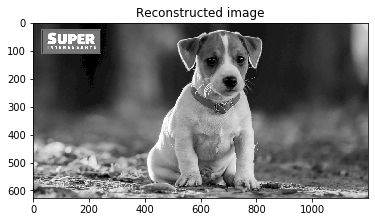

In [23]:
reconstructed_img = reconstruct_image(binary_buffer, vec_shape, huffman_dictionary)
plt.imshow(reconstructed_img , cmap = 'gray', clim=(0, 255)), plt.title('Reconstructed image')
plt.show()

# Final result
Rating image quality and compression

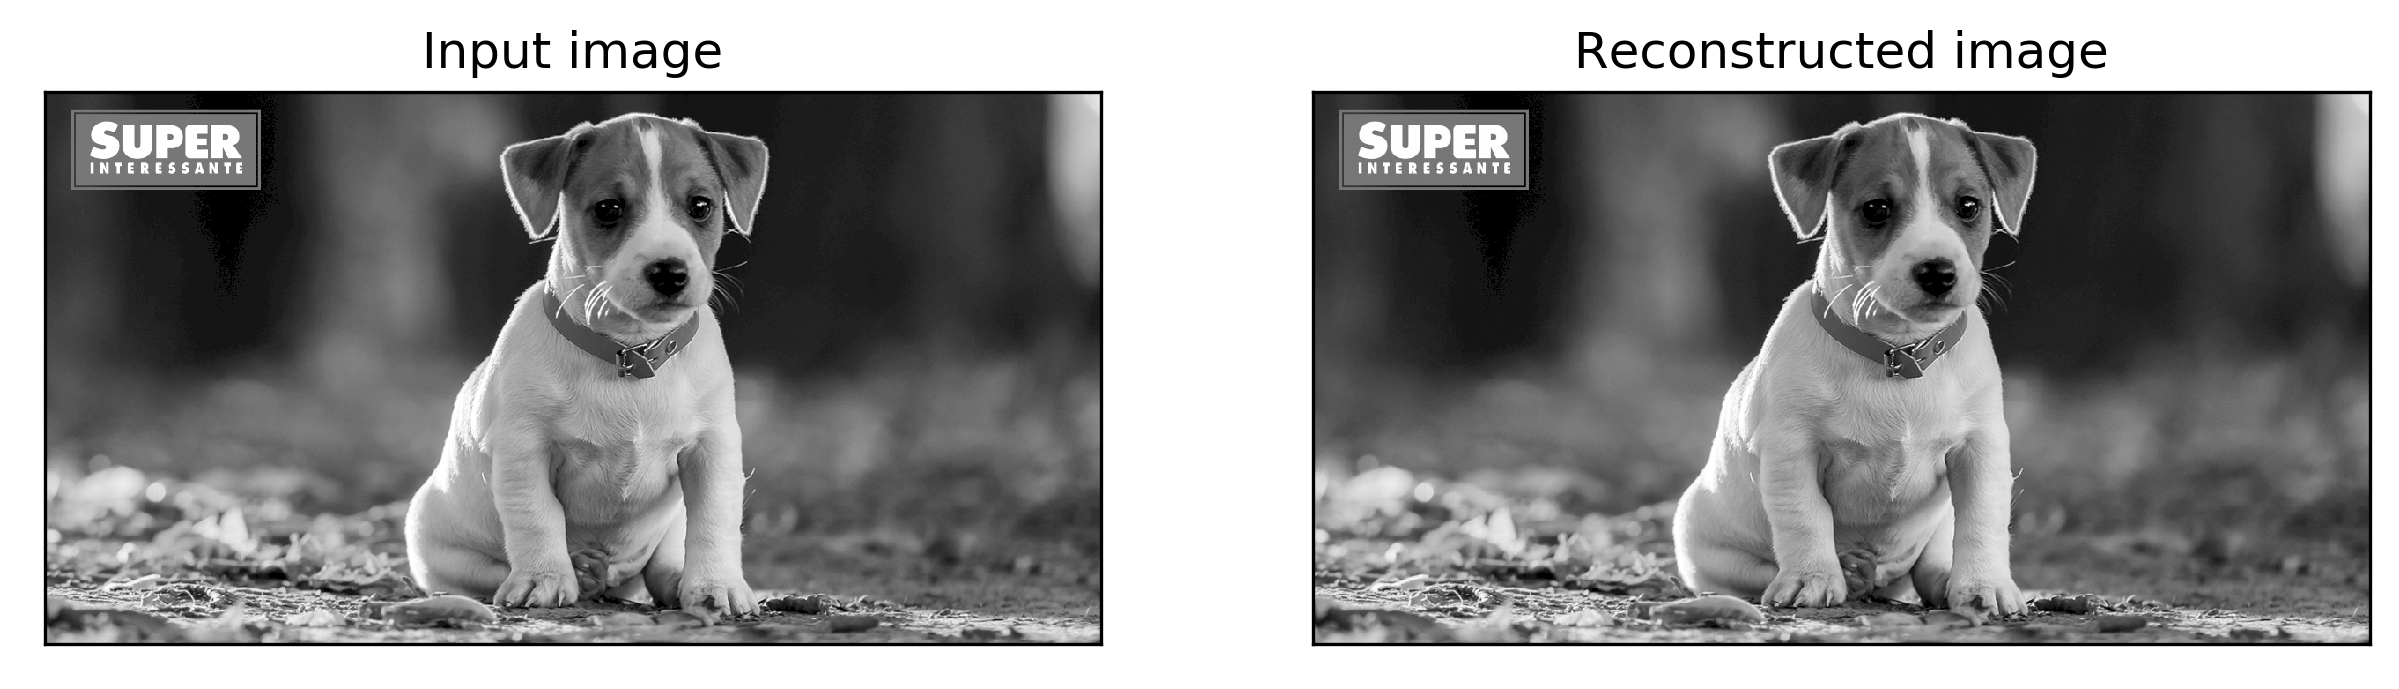

Input image size: 1119.28 Kb
Compressed image size: 689.28 Kb
Header size: 4.26 Kb

Total compressed image: 693.55 Kb
Compression rate: 62.0 %


In [24]:
fig, ax = plt.subplots(1,2, figsize=(10,10), dpi=300)

plt.subplot(121),plt.imshow(img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(reconstructed_img, cmap = 'gray', clim=(0, 255))
plt.title('Reconstructed image'), plt.xticks([]), plt.yticks([])
plt.show()

show_compression_rate(img_path, compressed_img_filename, header_filename)